# 04.04 - Modeling
+ Imports & Setup
+ Encode 'city' column via LeaveOneOutEncoder
+ Train Models with Defaul Settings
 + Select Models
 + Compare Results
+ Apply SMOTE to oversample data
+ Re-train Models Based on New Dataset (Oversampled Data)
 + Compare Results 
 + Tune Hyperparameters for Outperformed Models 
 + Choose Final Model

## Imports & Setup

In [123]:
import os
import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [3]:
df = pd.read_csv('data/preprocessed_train.csv')

In [4]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_149,0.689,1,1,0,2,1,1,2,4,1,106,0
1,city_83,0.923,1,1,0,2,1,3,1,2,1,69,0
2,city_16,0.910,1,1,0,2,1,2,1,1,1,4,0
3,city_64,0.666,1,1,0,2,1,3,1,4,1,26,0
4,city_100,0.887,1,0,0,2,1,2,1,4,1,88,1


In [5]:
df.shape

(18359, 13)

## Encode 'city' column via LeaveOneOutEncoder

In [6]:
X = df.drop(['target'],axis=1)
y = df['target']

In [7]:
# Encode column 'city'
enc = LeaveOneOutEncoder(cols=['city'])
X_enc = enc.fit_transform(X,y)
X_enc.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.125000,0.689,1,1,0,2,1,1,2,4,1,106
1,0.099291,0.923,1,1,0,2,1,3,1,2,1,69
2,0.093164,0.910,1,1,0,2,1,2,1,1,1,4
3,0.101695,0.666,1,1,0,2,1,3,1,4,1,26
4,0.159259,0.887,1,0,0,2,1,2,1,4,1,88


In [8]:
# Scale X 
X_scaled = StandardScaler().fit_transform(X_enc)

In [9]:
# Split train test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [10]:
# Confirm there's positive class in the test set.
y_test.value_counts()

0    4780
1     728
Name: target, dtype: int64

## Train Models with Defaul Settings

### Select Models

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def model_eval(model_name,X,y):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=5)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [12]:
# create a empty list to put the average model test_score from the validation
model_score_average = []

# list up models we want to explore with.
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

model_dict = dict(zip(index,models))


# Loop inside the model_dict and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
# Append the avarage score to list 'model_score_average' 
for model in model_dict.values():
    model_score_average.append(model_eval(model,X_os_train,y_os_train).mean())
    #model_score_average.append(model_eval(model,X_train,y_train).mean())

# put the model_score_average into a dataframe 
df_model_eval = pd.DataFrame(model_score_average,index=list(model_dic.keys())).round(5)
df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})

df_model_eval

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0172,0.0092,0.8678,0.0000,0.0000,0.0000,0.6404
1,GNB,0.0042,0.0092,0.8078,0.2598,0.2458,0.2524,0.6300
2,KNN,0.0788,0.3502,0.8546,0.2716,0.0598,0.0982,0.5600
3,SVC,13.8368,0.3166,0.8678,0.0000,0.0000,0.0000,0.5262
4,DT,0.0142,0.0046,0.9996,0.9982,0.9988,0.9984,0.9992
5,RF,0.5858,0.0840,0.9446,0.9960,0.5814,0.7336,0.9804
6,GB,0.5548,0.0094,0.9804,1.0000,0.8502,0.9188,0.9960
7,XGB,0.2346,0.0096,1.0000,1.0000,1.0000,1.0000,1.0000
8,LightGB,0.0990,0.0172,0.9986,0.9982,0.9918,0.9948,1.0000


### Compare results

As data is imbalanced so for some of the models, there's no positive class predicted, therefore Recall is zero, Precision and fscore are ill-defined.
We can fix this problem by either increase datas of positive classes (oversample) or decrease data of the negative classes (downsample).
As our original dataset does not contain huge amout of datas, oversampling will be a better way in this case.
We will use SMOTE to oversample our data.

## Apply SMOTE to oversample data

In [13]:
os = SMOTE(random_state=43)
#columns = X_train.columns

#os_data_X,os_data_y=os.fit_sample(X_train, y_train)
X_os, y_os=os.fit_sample(X_train, y_train.ravel())

In [14]:
print(X_os.shape)
print(y_os.shape)

(22308, 12)
(22308,)


In [15]:
# logreg=LogisticRegression()
# logreg.fit(X_train,y_train)

# y_pred=logreg.predict(X_test)

# score(y_test, y_pred, pos_label=1,average='binary') 
# metrics.confusion_matrix(y_test, y_pred,labels=[1,0])

As data is imbalanced so there's no positive class predicted, therefore Recall is zero, 
Precision and fscore are ill-defined.

In [16]:
# y_pred_proba = logreg.predict_proba(X_test)[:,1]
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

In [17]:
# plt.plot([0,1],[0,1],'k--')
# plt.plot(fpr, tpr)
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.show()

In [18]:
# auc = metrics.auc(fpr,tpr)
# print('AUC:{0:.3f}'.format(auc))

## Re-train models Based on New Dataset (Oversampled Data)

In [19]:
# make sure the numbers of positive and negative class are the same
np.unique(y_os,return_counts=True)

(array([0, 1]), array([11154, 11154]))

In [20]:
# Split the over sampled train_data: X_os, y_os to a new train_test set.
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_os, y_os, test_size=0.3, random_state=43)

In [21]:
np.unique(y_os_train,return_counts=True)

(array([0, 1]), array([7769, 7846]))

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def model_eval(model_name,X,y):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=5)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [113]:
# create a empty list to put the average model test_score from the validation
model_score_average = []

# list up models we want to explore with.
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

model_dict = dict(zip(index,models))


# Loop inside the model_dict and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
# Append the avarage score to list 'model_score_average' 
for model in model_dict.values():
    model_score_average.append(model_eval(model,X_os_train,y_os_train).mean())
    #model_score_average.append(model_eval(model,X_train,y_train).mean())

# put the model_score_average into a dataframe 
df_model_eval = pd.DataFrame(model_score_average,index=list(model_dic.keys())).round(5)
df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})

df_model_eval

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0130,0.0070,0.6058,0.6274,0.5320,0.5754,0.6436
1,GNB,0.0044,0.0098,0.6006,0.6324,0.4894,0.5518,0.6298
2,KNN,0.1116,0.3964,0.7330,0.6942,0.8378,0.7590,0.8094
3,SVC,22.2138,0.9428,0.6520,0.6674,0.6130,0.6388,0.7062
4,DT,0.0214,0.0050,0.9960,0.9988,0.9934,0.9962,0.9962
5,RF,0.7846,0.0890,0.9690,0.9790,0.9588,0.9688,0.9960
6,GB,0.9594,0.0122,0.9370,0.9328,0.9426,0.9376,0.9888
7,XGB,0.3016,0.0112,0.9982,1.0000,0.9966,0.9984,1.0000
8,LightGB,0.1326,0.0186,0.9956,1.0000,0.9910,0.9954,1.0000


### Compare results

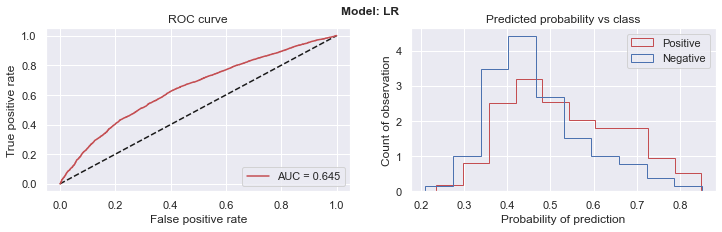

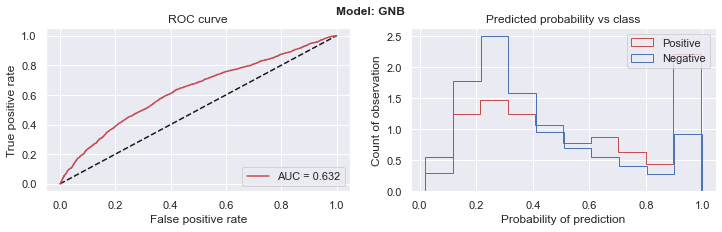

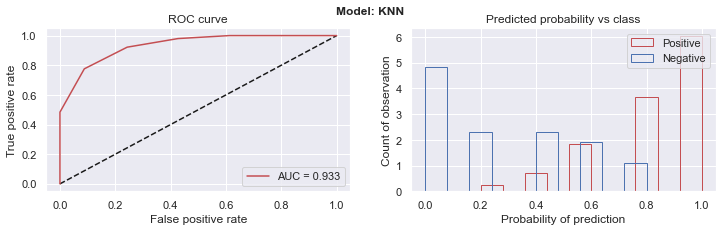

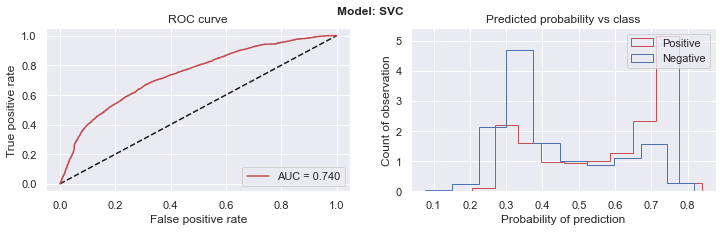

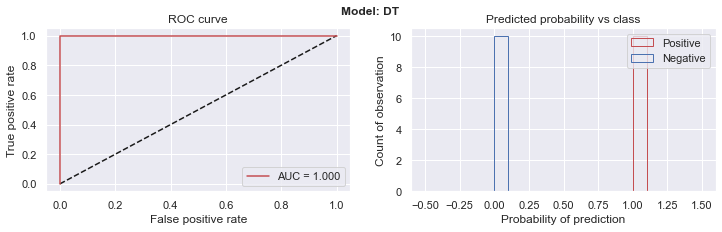

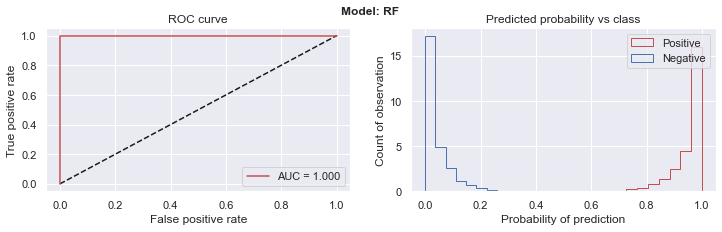

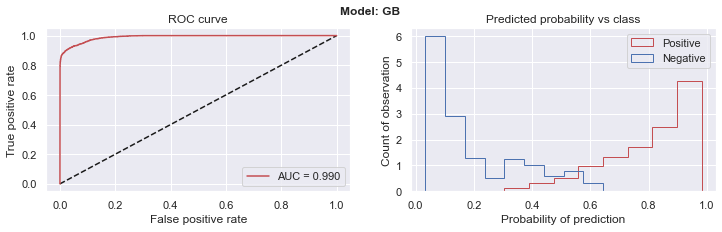

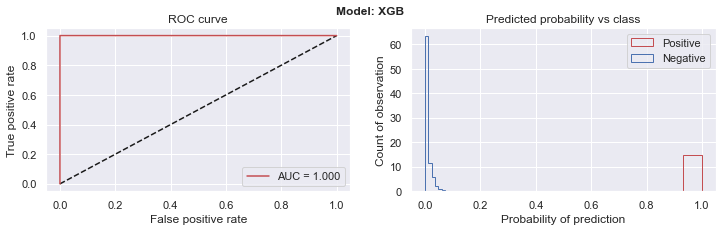

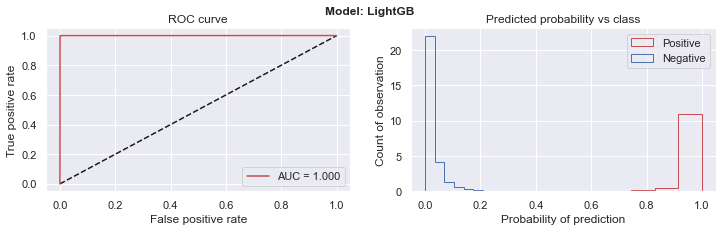

In [120]:
# visualize model performance on oversampled train dataset: X_os_train, y_os_train
kf = KFold(len(y_os_train), n_folds=5)

for index, model in model_dict.items():
    model.fit(X_os_train, y_os_train)
    y_os_pred_proba = model.predict_proba(X_os_train)[:,1]
    fpr, tpr, threshold = roc_curve(y_os_train, y_os_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,3)
    ax1.plot([0,1],[0,1],'k--')
    ax1.plot(fpr, tpr,'r', label='AUC = %.3f'%roc_auc)
    ax1.set_xlabel('False positive rate', fontsize=12)
    ax1.set_ylabel('True positive rate', fontsize=12)
    ax1.set_title('ROC curve',fontsize=12)
    ax1.legend(loc='lower right')
   
  
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = y_os_pred_proba
    predProba_label['label'] = np.array(y_os_train)
    predProba_label.head()
    ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
    ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Count of observation', fontsize=12)
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)

    plt.suptitle(("Model: %s" % index),fontsize=12,fontweight='bold')

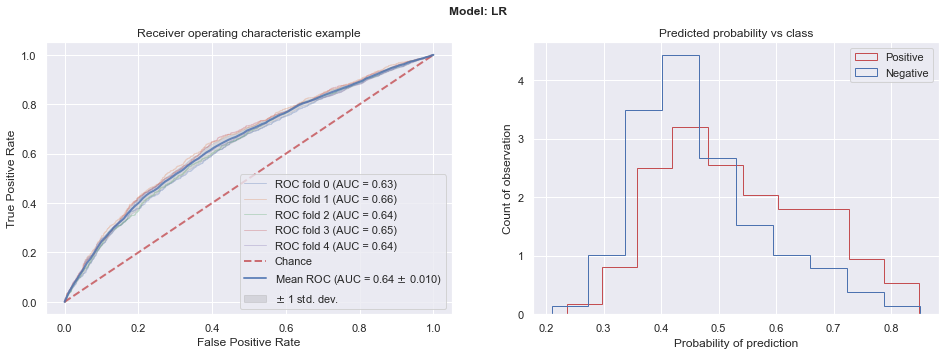

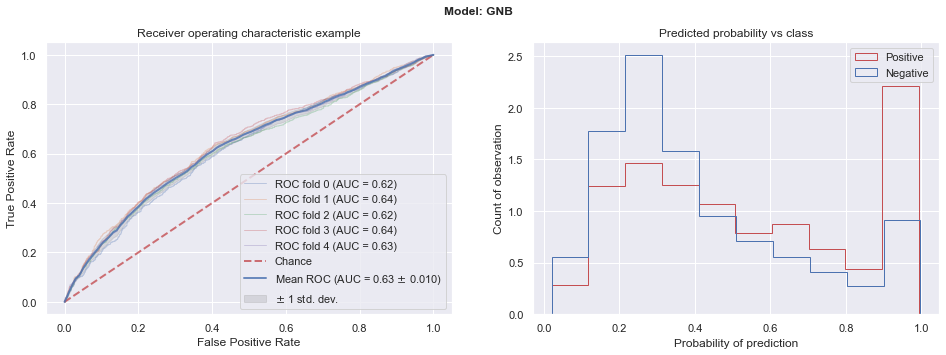

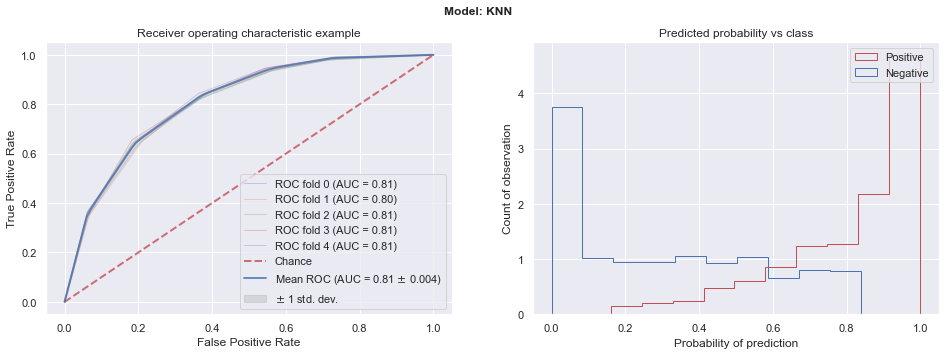

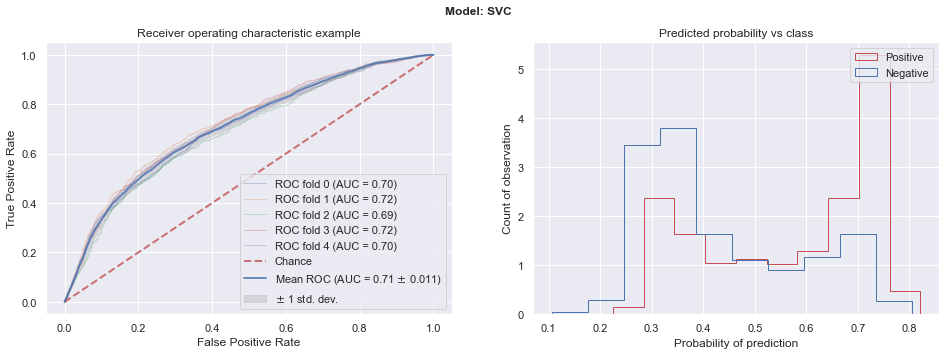

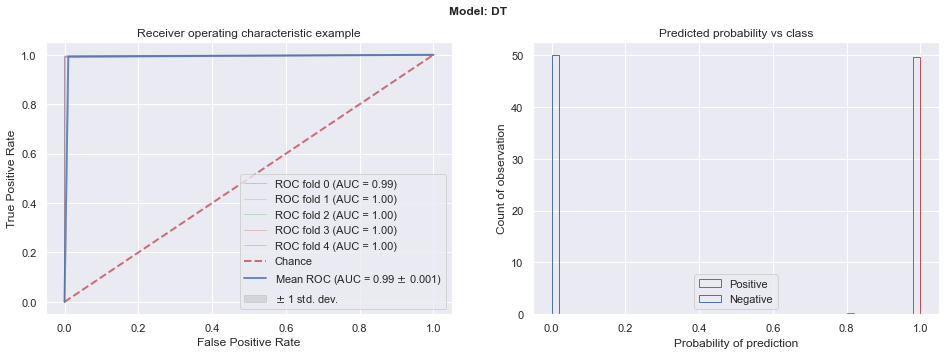

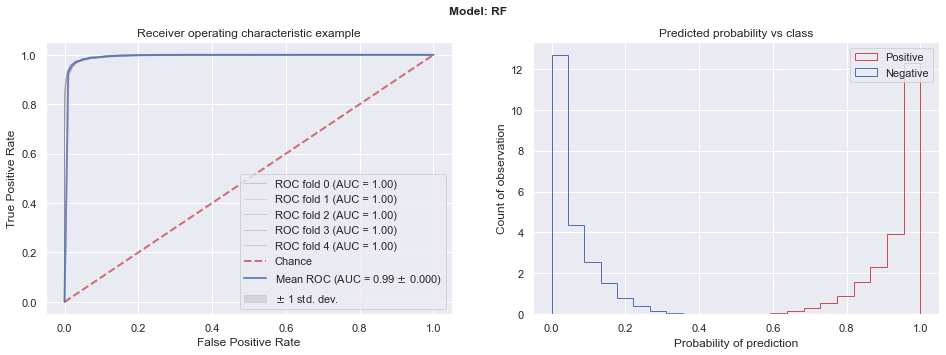

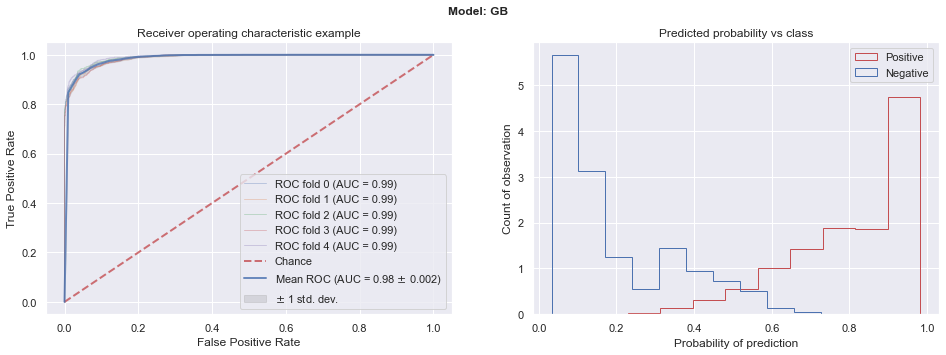

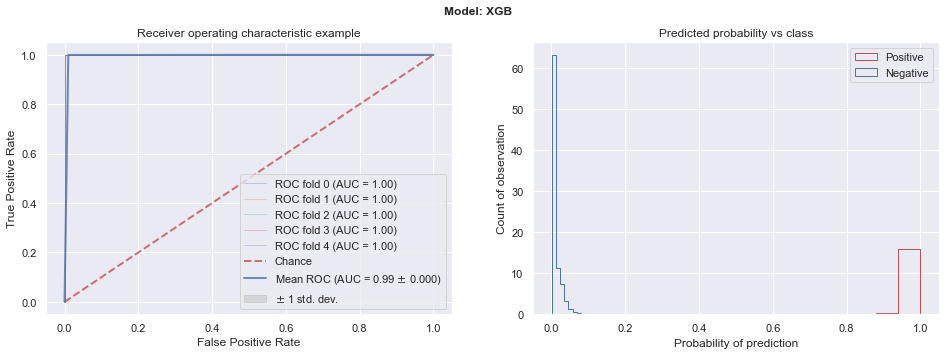

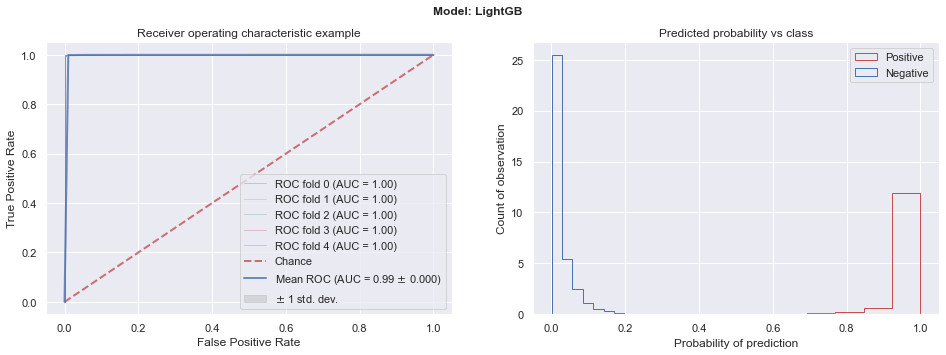

In [180]:
from sklearn.metrics import plot_roc_curve
cv = KFold(n_splits=5)

for index, model in model_dict.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    y_proba = []

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,5)
    for i, (train, test) in enumerate(cv.split(X_os_train, y_os_train)):
        model.fit(X_os_train[train], y_os_train[train])
        y_proba.append(model.predict_proba(X_os_train)[:,1])
        viz = plot_roc_curve(model, X_os_train[test], y_os_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax1)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
    ax1.legend(loc="lower right")

    
    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = pd.DataFrame(y_proba).mean()
    predProba_label['label'] = np.array(y_os_train)
    predProba_label.head()
    ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
    ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Count of observation', fontsize=12)
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)

    plt.suptitle(("Model: %s" % index),fontsize=12,fontweight='bold')

    plt.show()

As we can see after training oversampled data, logistic regression's performance auc score slightly increased from 0.629 to 0.648.
However still not as ideal as we would expect. We can check the predicted probability distribution, to see if we can increase our model accuracy by adjusting the threshold/cutoff (default 0.5).

As we can see from the predicted probability distribution, our two observation classes overlap among most of the probabilities.
Which means we can not optimize the model classification accuracy by lowering or raising the threshold/cut-off. Therefore in the next step we will use other classification models to train the oversampled data and see if we will get better result than logistic regression.

### Tune Hyperparameters for Outperformed Models.

In [ ]:
# np.unique(y_os_train,return_counts=True)

In [ ]:
$$$$ from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def model_eval(model_name,X,y):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=5)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [ ]:
# create a empty list to put the average model test_score from the validation
model_score_average = []

# list up models we want to explore with.
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

# Loop inside the models and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
# Append the avarage score to list 'model_score_average' 
for model in models:
    model_score_average.append(model_eval(model,X_os_train,y_os_train).mean())
    #model_score_average.append(model_eval(model,X_train,y_train).mean())

# put the model_score_average into a dataframe 
df_model_eval = pd.DataFrame(model_score_average,index=index).round(5)
df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})

df_model_eval

In [ ]:
fig,axs = plt.subplots(4,1, figsize=(6,12),sharex=True)

axs[0].barh('model', 'test_recall', data=df_model_eval)
axs[1].barh('model', 'test_f1_score', data=df_model_eval)
axs[2].barh('model', 'test_accuracy', data=df_model_eval)
axs[3].barh('model', 'test_roc_auc',data=df_model_eval)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('fscore')
axs[2].set_xlabel('accuracy')
axs[3].set_xlabel('roc_auc')


axs[0].plot([0.9,0.9],[-1,9],'r--')
axs[1].plot([0.9,0.9],[-1,9],'r--')
axs[2].plot([0.9,0.9],[-1,9],'r--')
axs[3].plot([0.9,0.9],[-1,9],'r--')
plt.show()

In [ ]:
# check std of each model score from the 5fold cross validation
model_score_std = []
index = ['DT','RF','GB','XGB','LightGB']
models = [DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

for model in models:
    model_score_std.append(model_eval(model,X_os_train,y_os_train).std())

df_model_std = pd.DataFrame(model_score_std,index=index).round(6)
df_model_std = df_model_std.reset_index().rename(columns={'index':'model'})

In [ ]:
df_model_std.sort_values(['test_recall','test_accuracy'])

We can see among 9 models, LightGB, XGB, GB, RF, DT overall have very good performance. (all metrics scores are higher than 0.9)
Especially XGB and LightGB models have very small variance comparing to GB, RF and DT. These two models are very likely to lead us to a more robust model. 
Therefore we will focus on LightGB and XGB in the next step to optimize their hyperparameters via BayesianOptimization. 

## 5. Model optimization: hyperparameter tuning (Bayesian optimization)

In [ ]:
$$$$ from bayes_opt import BayesianOptimization

### Hyperparameter tuning for Lightgbm

In [ ]:
def lgb_eval(learning_rate,num_leaves, max_depth, subsample, colsample_bytree, min_child_samples, 
             min_child_weight, min_data_in_leaf, L2, L1):
    
    params = {
        "objective" : "binary",
        "is_unbalance": True,
        "learning_rate" : learning_rate,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "subsample" : subsample,
        "colsample_bytree" : colsample_bytree,
        "min_child_samples" : int(min_child_samples),
        "min_child_weight" : int(min_child_weight),
        "min_data_in_leaf" : int(min_data_in_leaf),
        "reg_lambda" : L2,
        "reg_alpha" : L1,
        "num_threads" : 20,
        "subsample_freq" : 5,
        "random_state" : 43,
        "verbose": -1
      
    }
    lgtrain = lgb.Dataset(X_os_train, y_os_train)
   
    cv_result = lgb.cv(params,
                       lgtrain,
                       num_boost_round = 1000,
                       metrics='auc',
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    
    return cv_result['auc-mean'][-1]

In [ ]:
lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.4),
                                        'num_leaves': (25, 4000),
                                        'max_depth': (0, 100),
                                        'subsample': (0.5, 1),
                                        'colsample_bytree': (0.4,1),
                                        'min_child_samples': (50, 10000),
                                        'min_child_weight' : (0, 0.05),
                                        'min_data_in_leaf': (10, 2000),
                                        'L2': (0.0, 100),
                                        'L1': (0.0, 1)})

lgbBO.maximize(n_iter=10, init_points=2)

In [ ]:
lgbBO.max

In [ ]:
# test result of LGB model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)
model_eval(lgb.LGBMClassifier
           (objective='binary', 
            L1=0.214,
            L2=49,
            colsample_bytree=0.426,
            learning_rate= 0.346,
            max_depth = 10,
            min_child_samples= 4977,
            min_child_weight= 0.036,
            min_data_in_leaf= 28,
            num_leaves=49,
            subsample= 0.567,
            verbose=-1,
            random_state=43),
            X_os_test,y_os_test).mean()

In [ ]:
# Test result of LGB model with default value 
# dataset: X_os_test, y_os_test with crossvalidation(5)

model_eval(lgb.LGBMClassifier(objective='binary',random_state=43,verbose=-1),
           X_os_test,y_os_test).mean()

In [ ]:
# final test of LGB model with tuned hyperparameters on X_test, y_test without crossvalidation.
# dataset :X_test, y_test

model_lgb1 = lgb.LGBMClassifier(objective='binary', 
            L1=0.214,
            L2=49,
            colsample_bytree=0.426,
            learning_rate= 0.346,
            max_depth = 10,
            min_child_samples= 4977,
            min_child_weight= 0.036,
            min_data_in_leaf= 28,
            num_leaves=49,
            subsample= 0.567,
            verbose=-1,
            random_state=43)

start = time.time()
model_lgb1.fit(X_os_train,y_os_train)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = model_lgb1.predict(X_test)
end = time.time()

pred_time = end - start

# get precision, recall, fscore.
print(score(y_test, y_pred, pos_label=1,average='binary'))
print(fit_time)
print(pred_time)

In [ ]:
# final test of LGB model with default parameter values on X_test, y_test withou crossvalidation.
# dataset :X_test, y_test

model_lgb2 = lgb.LGBMClassifier(objective='binary', 
            random_state=43)
    
model_lgb2.fit(X_os_train,y_os_train)
y_pred = model_lgb2.predict(X_test)

# get precision, recall, fscore.
score(y_test, y_pred, pos_label=1,average='binary') 

## Hyperparameter tuning for XGB

In [ ]:
def XGB_eval(eta, gamma, subsample, colsample_bytree, max_depth, min_child_weight):
    params = {
        "objective" : "binary:logistic",
        "eta" : eta,
        "gamma" : gamma,
        "subsample" : subsample,
        "colsample_bytree" : colsample_bytree,
        "max_depth" : int(max_depth),
        "min_child_weight" : int(min_child_weight),
        #"lambda" : L2,
        #"alpha" : L1,
        "seed" : 43,
        "nthread": 4}
    
    
    xgtrain = xgb.DMatrix(X_os_train, label=y_os_train)
    cv_result =xgb.cv(params,
                      xgtrain,
                      early_stopping_rounds=100,
                      num_boost_round=70,
                      stratified=True,
                      nfold=3,
                      metrics= 'auc')
                       
          
    return cv_result['test-auc-mean'].iloc[-1]

In [ ]:
xgbBO = BayesianOptimization(XGB_eval, {'eta': (0.001,0.4),
                                        'gamma': (0,20),
                                        'subsample': (0.5,1),
                                        'colsample_bytree': (0,1),
                                        'max_depth': (1, 100),
                                        'min_child_weight': (0,20)
                                        #'L2':(0, 100),
                                        #'L1': (0, 1),
                                        })
                                        
                                        

xgbBO.maximize(n_iter=10, init_points=2)

In [ ]:
xgbBO.max

In [ ]:
# test result of XGB model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)

model_eval(XGBClassifier
           (#L1=0.318,
            #L2=26,
            objective='binary:logistic',
            colsample_bytree=0.471,
            gamma=2.080,
            eta= 0.084,
            max_depth = 49,
            min_child_weight=0.950,
            subsample=0.661,
            seed=43),
            X_os_test,y_os_test).mean()

In [ ]:
# test result of XGB model with default parameter values
# dataset: X_os_test, y_os_test with crossvalidation(5)

model_eval(XGBClassifier(
            objective='binary:logistic',
            seed=43),
            X_os_test,y_os_test).mean()

In [ ]:
# final test of XBG model with tuned hyperparameters on X_test, y_test without crossvalidation.
# dataset: X_test, y_test

model_xgb1 = XGBClassifier(objective='binary:logistic',
            colsample_bytree=0.471,
            gamma=2.080,
            eta= 0.084,
            max_depth = 49,
            min_child_weight=0.950,
            subsample=0.661,
            seed=43)

start = time.time()
model_xgb1.fit(X_os_train,y_os_train)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = model_xgb1.predict(X_test)
end = time.time()
pred_time = end - start

# get precision, recall, fscore.
print(score(y_test, y_pred, pos_label=1,average='binary'))
print(fit_time)
print(pred_time)

In [ ]:
# final test of XGB model with default parameter values on X_test, y_test withou crossvalidation.
# dataset: X_test, y_test

model_xgb2 =  XGBClassifier(random_state=43)
model_xgb2.fit(X_os_train,y_os_train)
y_pred = model_xgb2.predict(X_test)

# get precision, recall, fscore.
score(y_test, y_pred, pos_label=1,average='binary') 

In [ ]:
## Hyperparameter tuning for RF

In [ ]:
# from sklearn.model_selection import cross_val_score

In [ ]:
# def rf_cv(X, y, **kwargs):
#     estimator = RandomForestClassifier(**kwargs)
#     cval = cross_val_score(estimator, X, y, scoring = 'roc_auc', cv = 3)
#     #cval = cross_val_score(estimator, X_train, y_train, scoring = 'roc_auc', cv = 3)
#     return cval.mean()


# def BayesianOptimization_rf(X, y):
#     def rf_crossval(n_estimators,  max_depth, 
#                     min_samples_split, max_leaf_nodes, min_samples_leaf,random_state=43):
        
#         return rf_cv(
#             X = X,
#             y = y,
#             bootstrap = True)
    
#     rfBO = BayesianOptimization(
#         f = rf_crossval,
#         pbounds = {
#             "n_estimators" : (10, 400),
#             #"max_features" : 
#             "max_depth" : (0,50),
#             "min_samples_split" : (0,5000),
#             "max_leaf_nodes" : (0,200),
#             "min_samples_leaf" : (0,0.5)
#         }
#     )
#     rfBO.maximize(n_iter = 10,init_points=2)
#     print("Final result:", rfBO.max)

In [ ]:
#BayesianOptimization_rf(X_os_train,y_os_train)

In [ ]:
# model = RandomForestClassifier(max_depth=6.24, 
#                                max_leaf_nodes=157, min_samples_leaf=0.075,
#                                min_samples_split=2216,random_state=43)

In [ ]:
## Hyperparameter tuning for LogisticRegression

In [ ]:
# def lr_cv(X, y, **kwargs):
#     estimator = LogisticRegression(**kwargs)
#     cval = cross_val_score(estimator, X, y, scoring = 'recall', cv = 3)
#     return cval.mean()


# def BayesianOptimization_lr(X, y):
#     def lr_crossval(C):
        
#         return rf_cv(
#             X = X,
#             y = y)
    
#     lrBO = BayesianOptimization(
#         f = lr_crossval,
#         pbounds = {
#             "C" : (0, 1000)
#             #"l2" : (0,100)
#         }
#     )
#     lrBO.maximize(n_iter = 10,init_points=2)
#     print("Final result:", lrBO.max)

In [ ]:
#BayesianOptimization_lr(X_os_train,y_os_train)

## Final model

As we can see lightgb and xgb both perform very well, and their scores are really close.
We choose to use lightgb as the final model, as the data fit time for lgb is 8 times faster than xgb while predict times are both around less than 0.02s.

In [ ]:
fin_model =lgb.LGBMClassifier(objective='binary', 
            L1=0.214,
            L2=49,
            colsample_bytree=0.426,
            learning_rate= 0.346,
            max_depth = 10,
            min_child_samples= 4977,
            min_child_weight= 0.036,
            min_data_in_leaf= 28,
            num_leaves=49,
            subsample= 0.567,
            verbose=-1,
            random_state=43)

fin_model.fit(X_os_train, y_os_train)
fin_y_pred = fin_model.predict(X_test)

# get precision, recall, fscore
score(y_test, fin_y_pred, pos_label=1,average='binary')    

In [ ]:
lgb_fpr,lgb_tpr,threshold = roc_curve(y_test,fin_model.predict_proba(X_test)[:,1])
roc_auc_ = metrics.auc(lgb_fpr,lgb_tpr)
plt.figure(figsize=(6,6))
_=plt.plot([0,1],[0,1],'k--')
_=plt.plot(lgb_fpr,lgb_tpr,'r',label='AUC = %.3f'%roc_auc_)
_=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
_=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
_=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
_=plt.legend(loc='lower right')

#plt.savefig('figures/roc.jpg', dpi=300, bbox_inches='tight')

In [ ]:
(fin_y_pred == y_test).value_counts()

In [ ]:
metrics.confusion_matrix(y_test, y_pred,labels=[1,0])